# Combining Different Models for Ensemble Learning

In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like, shape=[n_classifiers]
        Different classifiers for the ensemble
    
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on the argmax of class labels.
        Else if 'probability', the argmax of the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights : array-like, shape=[n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are provided, the classifiers are weighted by importance;
        Uses uniform weights if `weights=None`.
        
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ Fit classifiers
        
        Paremeters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape=[n_samples]
            Vector of target class labels
            
        Returns
        ----------
        self : object
        
        """
        #print('fit called X shape: %s' % len(X))
        # Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class 
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of samples
            
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            #print(maj_vote)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            #print('predict called')
            return maj_vote
        
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and n_features is the number of features.
            
        Returns
        ----------
        avg_proba : array-like,
            shape=[n_samples, n_classes]
            Weighted average probability for each class per sample
        """
        #print('predict_proba called')
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        #print(avg_proba.shape)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

# Combining different algorithms for classification with majority vote

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [4]:
X_train.shape

(50, 2)

In [5]:
y_train.shape

(50,)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:
ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [7]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


In [8]:
import platform
print(platform.python_version())

2.7.14


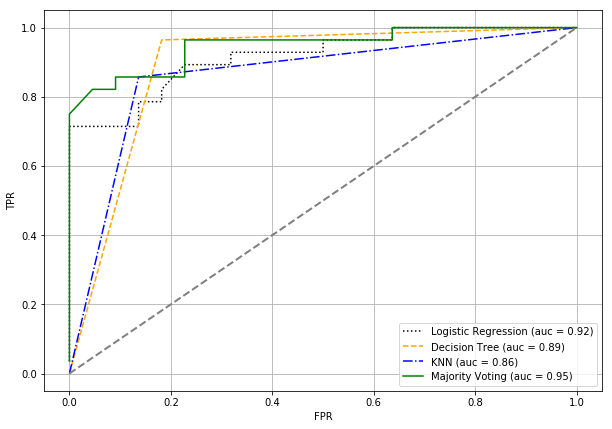

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import  matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %.2f)' % (label, roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

**Plot decision region**

In [10]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
print(xx.ravel().shape)

(3534,)


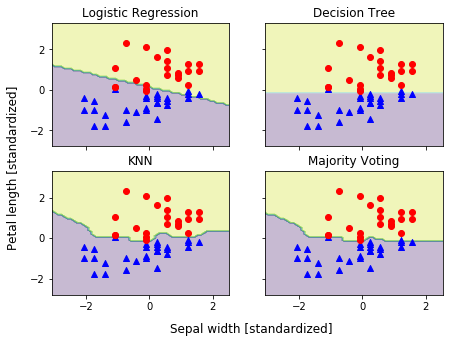

In [11]:
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='b', marker='^')
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='r', marker='o')
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-11, 3.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [12]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [13]:
mv_clf.get_params(False)

{'classifiers': [Pipeline(memory=None,
       steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]),
  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=0,
              splitter='best'),
  Pipeline(memory=None,
       steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors

In [15]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pipeline-1__clf__C': [0.001, 0.1, 100.0], 'decisiontreeclassifier__max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
grid.grid_scores_

D:\anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1},
 mean: 1.00000, std: 0.00000, params: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2},
 mean: 1.00000, std: 0.00000, params: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}]

In [17]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}

In [18]:
grid.best_score_

1.0